In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import astropy
import corner
import astroquery
import sklearn as skl
import seaborn as sns
import scipy
import statsmodels.api as sm

from skimage import data
from skimage.feature import match_template
from scipy.signal import find_peaks
import math
from scipy.stats import norm
from sklearn.mixture import GaussianMixture

# Simulate Point Sources

In [2]:
np.random.seed(27)

In [3]:
#adopt a "central" pixel view
x = np.linspace(0, 499, 500)
y = np.linspace(0, 499, 500)

xx, yy = np.meshgrid(x, y,indexing='ij')


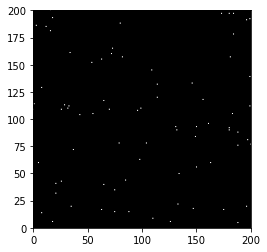

In [4]:
image = np.zeros((500, 500))
simpleRandomPoints = np.array([np.random.rand(500)*500,np.random.rand(500)*500]).T
for point in simpleRandomPoints:
    image[int(point[0]), int(point[1])] = 100

plt.imshow(image,vmin=0,vmax=100,cmap='gray', origin='lower')
plt.xlim(0,200)
plt.ylim(0,200)
plt.show()

In [5]:
from scipy.stats import rv_continuous
class flux_distr(rv_continuous):
    "Gaussian distribution"
    def _cdf(self, x):
        return x**(-3/2)
    def _rvs(self, size):
        uniformSamples = np.random.rand(size)
        return uniformSamples**(-2/3)
    def _pdf(self, x):
        return x**(-5/2)
flux_distribution = flux_distr(name='flux_distribution')

In [6]:
simpleRandomPoints
df = pd.DataFrame(simpleRandomPoints.astype(int), columns=['x', 'y'])
df['color'] = np.random.normal(loc=2,scale=0.5,size=len(df))
df['f1'] = flux_distribution._rvs(size=len(df))
df['log_f1'] = np.log(df['f1'])
df['f2'] = df['f1']*np.exp(df['color'])
df['log_f2'] = np.log(df['f2'])
print(df)

       x    y     color        f1    log_f1         f2    log_f2
0    212  414  2.059285  1.228087  0.205458   9.628643  2.264742
1    407  345  2.791439  2.069449  0.727282  33.741267  3.518722
2    367  119  1.977362  1.929457  0.657238  13.937747  2.634601
3    434  266  1.568994  1.154375  0.143559   5.543094  1.712553
4    191  196  2.418902  4.299606  1.458523  48.299720  3.877426
..   ...  ...       ...       ...       ...        ...       ...
495  428  260  1.701282  1.333322  0.287674   7.307897  1.988955
496  215  384  1.323026  1.458928  0.377702   5.477930  1.700727
497  323  441  1.785642  1.062717  0.060829   6.337415  1.846471
498   15   75  1.806623  1.017951  0.017792   6.199166  1.824415
499  256  195  1.698525  1.008033  0.008001   5.509787  1.706526

[500 rows x 7 columns]


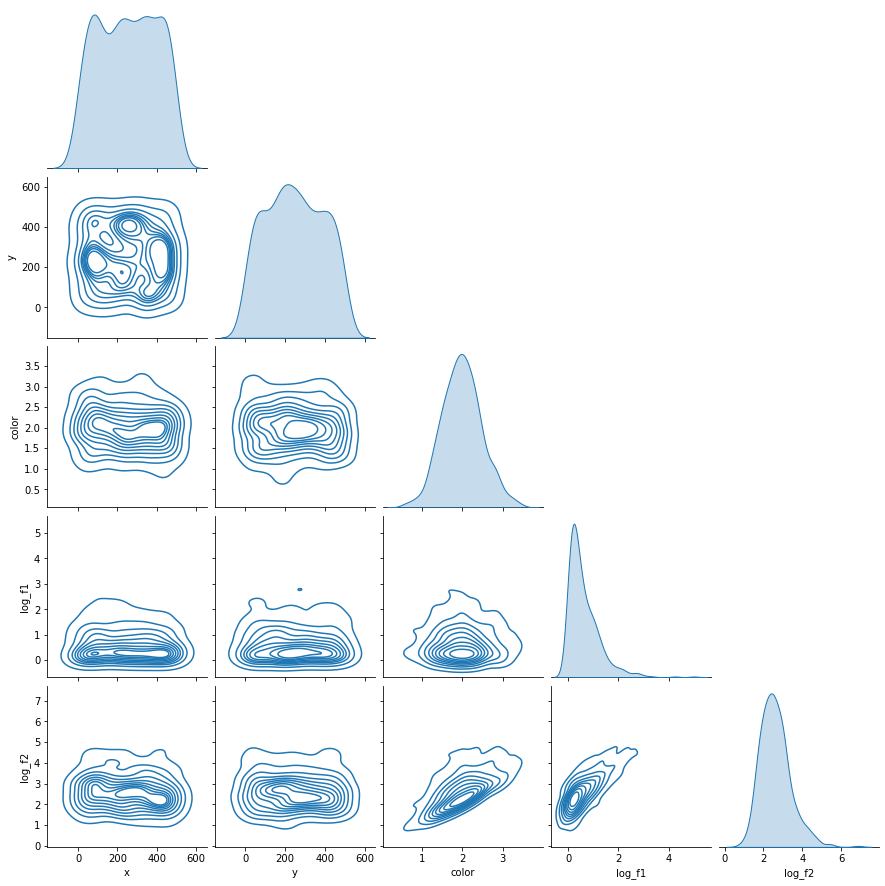

In [7]:
sns.pairplot(data=df, vars=['x', 'y', 'color', 'log_f1','log_f2'],kind='kde',corner=True)
plt.show()

# Simulate Images based on point sources

In [8]:
def gaussian_psf(flux, xcenter, ycenter, size, fwhm=2.5):
    """
    Generates a 2D Gaussian PSF.

    Args:
        size (int): The size of the PSF array.
        fwhm (float): The full width at half maximum of the Gaussian.

    Returns:
        numpy.ndarray: A 2D Gaussian PSF.
    """
    
    x, y = np.indices((size, size))
    
    sigma = fwhm / (2 * np.sqrt(2 * np.log(2)))
    gaussian = flux*np.exp(-((x - xcenter)**2 + (y - ycenter)**2) / (2 * sigma**2))
    
    return gaussian 

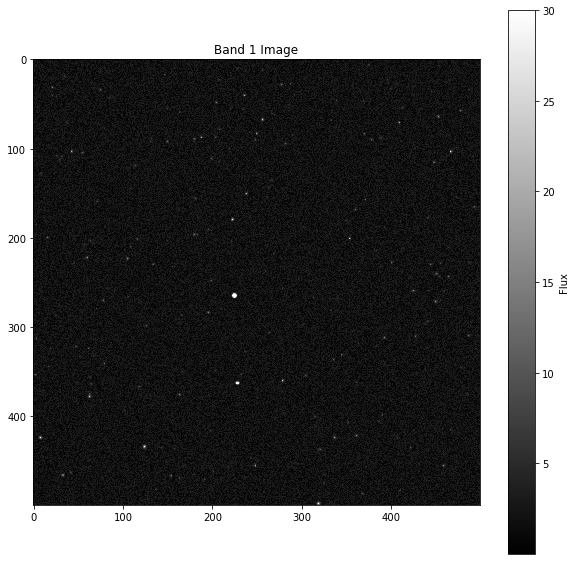

In [9]:
fig,ax = plt.subplots(figsize=(10, 10))

x = np.linspace(0, 499, 500)
y = np.linspace(0, 499, 500)

xx, yy = np.meshgrid(x, y,indexing='ij')
f1image = np.zeros((500, 500))
f1imageSignal = np.zeros((500, 500))
f1imageNoise = np.zeros((500, 500))


for index, row in df.iterrows():
    f1image[int(row['x']),int(row['y'])] = np.random.poisson(row['f1'], size=1)
    f1image += gaussian_psf(f1image[int(row['x']),int(row['y'])],int(row['x']), int(row['y']), size=500, fwhm=2.5)
f1imageSignal = f1image

noiseLevel = math.ceil(75*np.sum(f1image[~np.isnan(image)])/(500*500))
f1imageNoise = np.random.uniform(0, noiseLevel,size=250000)
f1imageNoise = f1imageNoise.reshape((500, 500))
f1image += f1imageNoise


plt.imshow(f1image, vmax=30, cmap='gray',interpolation='None')
plt.colorbar(label='Flux')
plt.title("Band 1 Image")
plt.show()

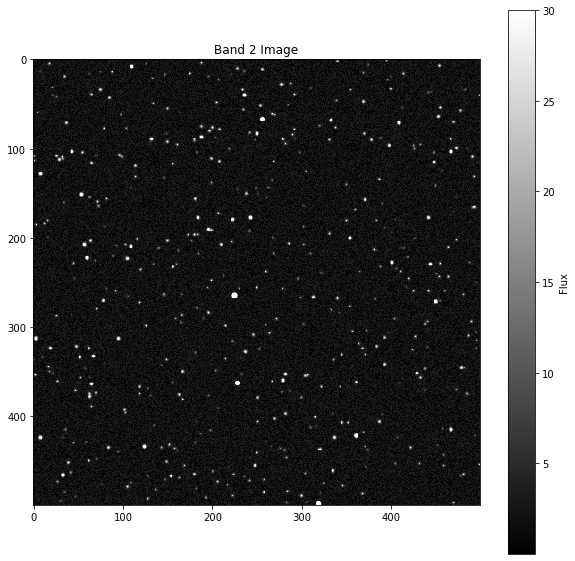

In [10]:
fig,ax = plt.subplots(figsize=(10, 10))

x = np.linspace(0, 499, 500)
y = np.linspace(0, 499, 500)

xx, yy = np.meshgrid(x, y,indexing='ij')
f2image = np.zeros((500, 500))
f2imageSignal = np.zeros((500, 500))
f2imageNoise = np.zeros((500, 500))


for index, row in df.iterrows():
    f2image[int(row['x']),int(row['y'])] = np.random.poisson(row['f2'], size=1)
    f2image += gaussian_psf(f2image[int(row['x']),int(row['y'])],int(row['x']), int(row['y']), size=500, fwhm=2.5)
f2imageSignal = f2image

#assume that noise is uniform between each band so we can use the same noise level
f2imageNoise = np.random.uniform(0, noiseLevel,size=250000)
f2imageNoise = f2imageNoise.reshape((500, 500))
f2image += f2imageNoise


plt.imshow(f2image, vmax=30, cmap='gray',interpolation='None')
plt.colorbar(label='Flux')
plt.title("Band 2 Image")
plt.show()

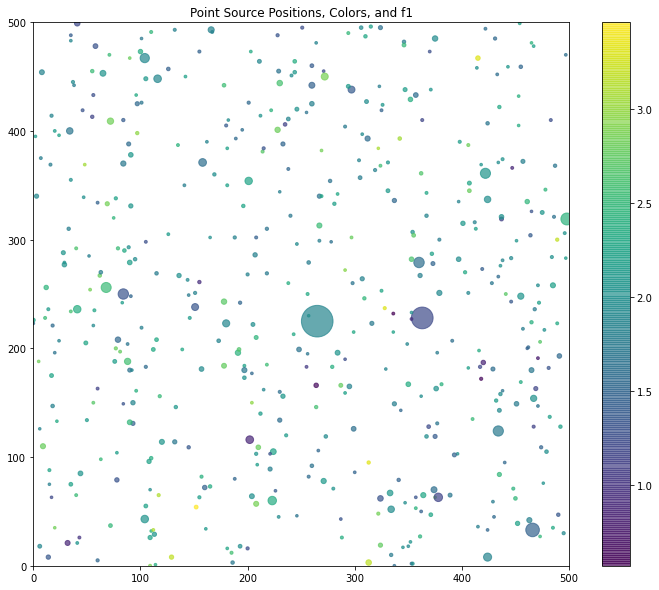

In [14]:
fig,ax = plt.subplots(figsize=(12, 10))
normalizedData = df['f1']/np.max(df['f1'])
plt.scatter(df['x'], df['y'], c=df['color'], s=1000*normalizedData, cmap='viridis', alpha=0.70)
plt.title("Point Source Positions, Colors, and f1")
plt.xlim(0, 500)
plt.ylim(0, 500)
plt.colorbar()
plt.show()

### Determine Detectable Sources 

Based on our image we want to determine what sources are realistically detectable (with SNR of at least 5).

In [11]:
TruePositive = []
TruePositiveDF = pd.DataFrame(columns=['x', 'y', 'f1', 'color'])
for index, row in df.iterrows():
    if f1imageSignal[int(row['x']),int(row['y'])]/f1imageNoise[int(row['x']),int(row['y'])] > 5 or f1imageSignal[int(row['x']),int(row['y'])]/f2imageNoise[int(row['x']),int(row['y'])] > 5:
        TruePositive.append([row['x'], row['y'], row['f1'], row['color']])
        TruePositiveDF = TruePositiveDF.append({'x': row['x'], 'y': row['y'], 'f1': row['f1'], 'color': row['color']}, ignore_index=True)
print(len(TruePositive))

239


# Point Source Finding

In [12]:
def getCenteredCandidatePositions(candidatePositions):
    trueCandidates = []
    candidatePositions = np.array(candidatePositions)
    for candidate in candidatePositions:
        #closePoints = []
        closePoints = candidatePositions[np.sqrt((candidate[0]-candidatePositions[:,0])**2+(candidate[1]-candidatePositions[:,1])**2)<=2]
        if len(closePoints)==0:
            trueCandidates.append(candidate)
            continue
        avgX = int(np.median(closePoints[:,0]))
        avgY = int(np.median(closePoints[:,1]))
        if np.array([avgX,avgY]) in np.array(trueCandidates):
            continue
        trueCandidates.append(np.array([avgX,avgY]))
        #print(np.array([avgX,avgY]))
    return trueCandidates

## Outlier Detection

In [14]:
def outlierDetection(windowSize,moveSize,sigmaThreshold):
    candidatePositions = []


    for i in range(0,500,moveSize):
        for j in range(0,500,moveSize):
            f1imageSection = f1image[i:min(500,i+windowSize),j:min(500,j+windowSize)]
            mean = np.mean(f1imageSection)
            std = np.std(f1imageSection)
            threshold = mean + sigmaThreshold*std
            row, column = np.where(f1imageSection >= threshold)
            for k in range(0,len(row)):
                candidatePositions.append(np.array([row[k]+i,column[k]+j]))
            
            f2imageSection = f2image[i:min(500,i+windowSize),j:min(500,j+windowSize)]
            mean = np.mean(f2imageSection)
            std = np.std(f2imageSection)
            threshold = mean + sigmaThreshold*std
            row, column = np.where(f2imageSection >= threshold)
            for k in range(0,len(row)):
                candidatePositions.append(np.array([row[k]+i,column[k]+j]))

    candidatePositions = np.unique(candidatePositions, axis=0)
    return candidatePositions

/home/tegan/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if sys.path[0] == '':


284


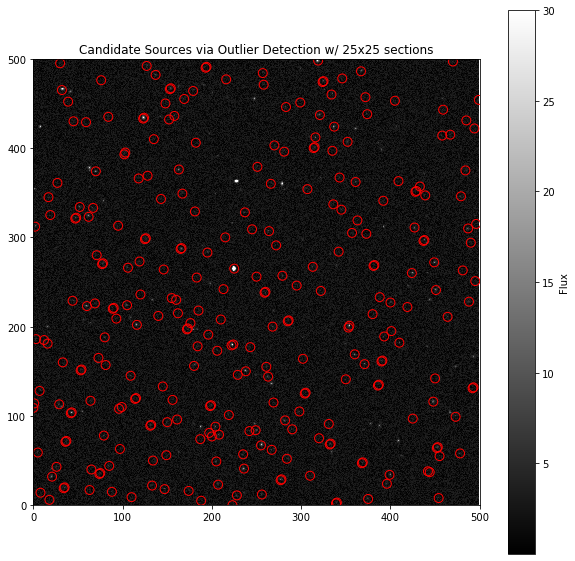

In [135]:
candidatePositions = getCenteredCandidatePositions(outlierDetection(25,25,3))
print(len(candidatePositions))

fig,ax = plt.subplots(figsize=(10, 10))
candidateSources = np.array(candidatePositions)
candidateImage = np.zeros((500, 500))
for candidate in candidateSources:
    #candidateImage[int(candidate[0]),int(candidate[1])] = 1
    ax.add_artist(plt.Circle((candidate[1], candidate[0]), 5, color='red', fill=False))
plt.imshow(f1image, vmax=30,cmap='gray',origin='lower',interpolation='None')
plt.colorbar(label='Flux')
plt.title("Candidate Sources via Outlier Detection w/ 25x25 sections")
plt.xlim(0, 500)
plt.ylim(0, 500)
plt.show()

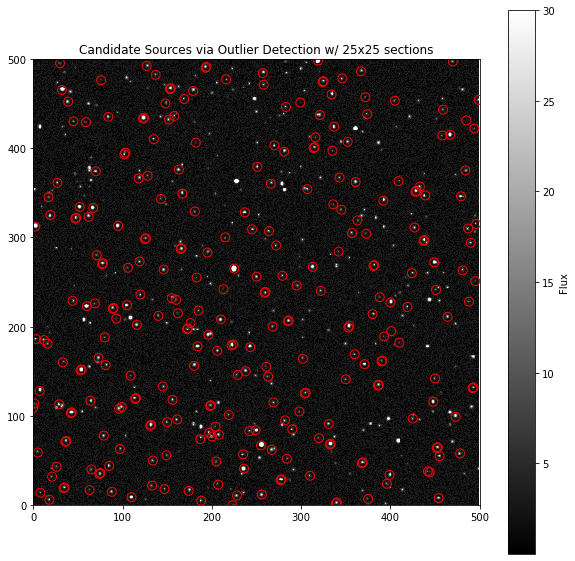

In [136]:
fig,ax = plt.subplots(figsize=(10, 10))
candidateSources = np.array(candidatePositions)
candidateImage = np.zeros((500, 500))
for candidate in candidateSources:
    #candidateImage[int(candidate[0]),int(candidate[1])] = 1
    ax.add_artist(plt.Circle((candidate[1], candidate[0]), 5, color='red', fill=False))
plt.imshow(f2image, vmax=30,cmap='gray',interpolation='None')
plt.colorbar(label='Flux')
plt.title("Candidate Sources via Outlier Detection w/ 25x25 sections")
plt.xlim(0, 500)
plt.ylim(0, 500)
plt.show()

### 50x50 Sections

/home/tegan/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if sys.path[0] == '':


307


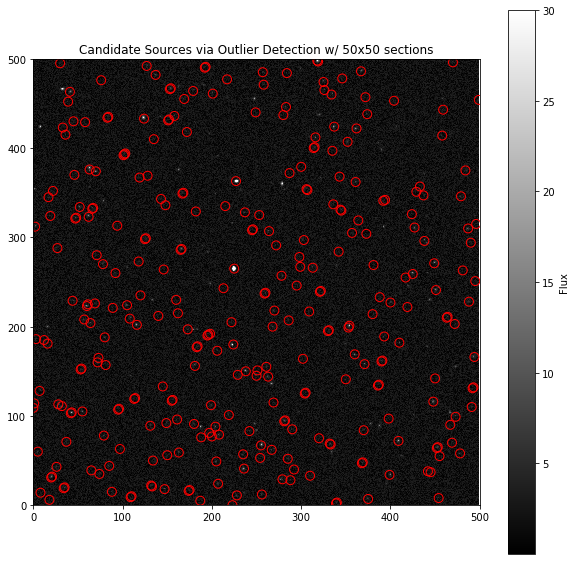

In [145]:
candidatePositions = getCenteredCandidatePositions(outlierDetection(50,25,3))
print(len(candidatePositions))

fig,ax = plt.subplots(figsize=(10, 10))
candidateSources = np.array(candidatePositions)
candidateImage = np.zeros((500, 500))
for candidate in candidateSources:
    #candidateImage[int(candidate[0]),int(candidate[1])] = 1
    ax.add_artist(plt.Circle((candidate[1], candidate[0]), 5, color='red', fill=False))
plt.imshow(f1image, vmax=30,cmap='gray',origin='lower',interpolation='None')
plt.colorbar(label='Flux')
plt.title("Candidate Sources via Outlier Detection w/ 50x50 sections")
plt.xlim(0, 500)
plt.ylim(0, 500)
plt.show()

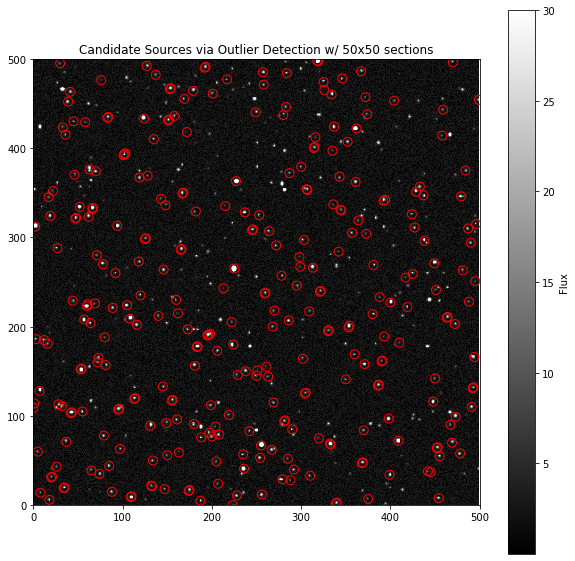

In [146]:
fig,ax = plt.subplots(figsize=(10, 10))
candidateSources = np.array(candidatePositions)
candidateImage = np.zeros((500, 500))
for candidate in candidateSources:
    #candidateImage[int(candidate[0]),int(candidate[1])] = 1
    ax.add_artist(plt.Circle((candidate[1], candidate[0]), 5, color='red', fill=False))
plt.imshow(f2image, vmax=30,cmap='gray',interpolation='None')
plt.colorbar(label='Flux')
plt.title("Candidate Sources via Outlier Detection w/ 50x50 sections")

plt.xlim(0, 500)
plt.ylim(0, 500)
plt.show()

### 100x100 Sections

/home/tegan/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if sys.path[0] == '':


304


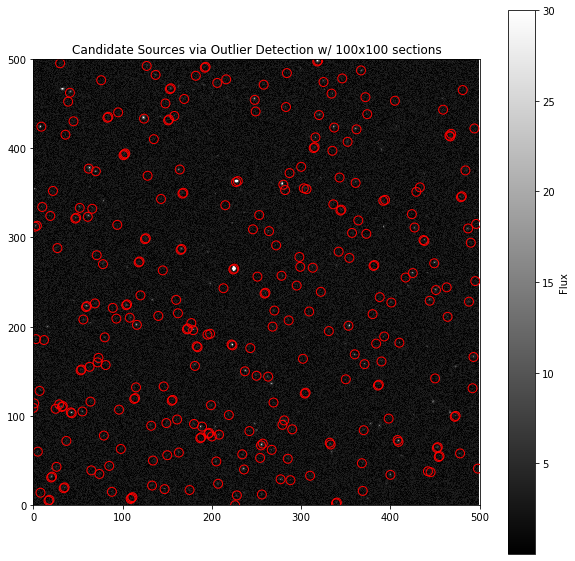

In [141]:
candidatePositions = getCenteredCandidatePositions(outlierDetection(100,25,3))
print(len(candidatePositions))

fig,ax = plt.subplots(figsize=(10, 10))
candidateSources = np.array(candidatePositions)
candidateImage = np.zeros((500, 500))
for candidate in candidateSources:
    #candidateImage[int(candidate[0]),int(candidate[1])] = 1
    ax.add_artist(plt.Circle((candidate[1], candidate[0]), 5, color='red', fill=False))
plt.imshow(f1image, vmax=30,cmap='gray',interpolation='None')
plt.colorbar(label='Flux')
plt.title("Candidate Sources via Outlier Detection w/ 100x100 sections")
plt.xlim(0, 500)
plt.ylim(0, 500)
plt.show()

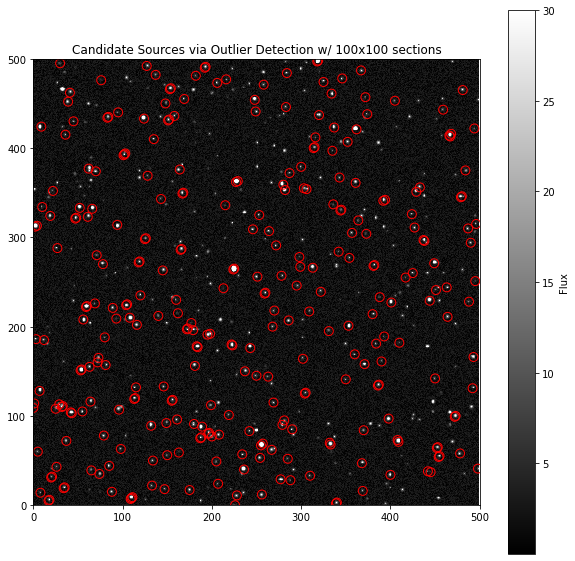

In [142]:
fig,ax = plt.subplots(figsize=(10, 10))
candidateSources = np.array(candidatePositions)
candidateImage = np.zeros((500, 500))
for candidate in candidateSources:
    #candidateImage[int(candidate[0]),int(candidate[1])] = 1
    ax.add_artist(plt.Circle((candidate[1], candidate[0]), 5, color='red', fill=False))
plt.imshow(f2image, vmax=30,cmap='gray',interpolation='None')
plt.colorbar(label='Flux')
plt.title("Candidate Sources via Outlier Detection w/ 100x100 sections")
plt.xlim(0, 500)
plt.ylim(0, 500)
plt.show()

### No Sections

/home/tegan/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if sys.path[0] == '':


228


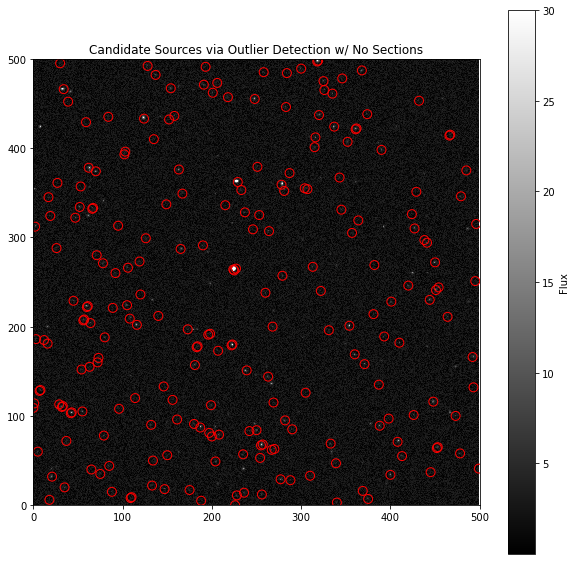

In [143]:
candidatePositions = getCenteredCandidatePositions(outlierDetection(500,500,3))
print(len(candidatePositions))

fig,ax = plt.subplots(figsize=(10, 10))
candidateSources = np.array(candidatePositions)
candidateImage = np.zeros((500, 500))
for candidate in candidateSources:
    #candidateImage[int(candidate[0]),int(candidate[1])] = 1
    ax.add_artist(plt.Circle((candidate[1], candidate[0]), 5, color='red', fill=False))
plt.imshow(f1image, vmax=30,cmap='gray',interpolation='None')
plt.colorbar(label='Flux')
plt.title("Candidate Sources via Outlier Detection w/ No Sections")
plt.xlim(0, 500)
plt.ylim(0, 500)
plt.show()

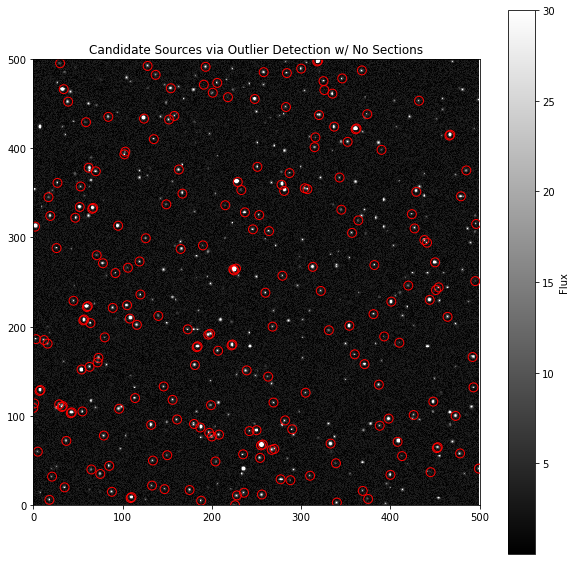

In [144]:
fig,ax = plt.subplots(figsize=(10, 10))
candidateSources = np.array(candidatePositions)
candidateImage = np.zeros((500, 500))
for candidate in candidateSources:
    ax.add_artist(plt.Circle((candidate[1], candidate[0]), 5, color='red', fill=False))
plt.imshow(f2image, vmax=30,cmap='gray',interpolation='None')
plt.colorbar(label='Flux')
plt.title("Candidate Sources via Outlier Detection w/ No Sections")
plt.xlim(0, 500)
plt.ylim(0, 500)
plt.show()

## Template Matching

In [15]:
def templateMatch(threshold,maxFlux1=100,maxFlux2=200):  
    #make it so that the template is a proper size for the flux and is centered
    i = 0
    for exFlux in range(5, maxFlux1):
        exPointSource = gaussian_psf(exFlux,5,5,11,fwhm=2.5)

        result = match_template(f1image, exPointSource,pad_input=True)
        resultIndices = np.argwhere(result >= threshold)
        if(i==0):
            candidatePositions = resultIndices
        else:
            candidatePositions = np.append(candidatePositions, resultIndices,axis=0)

        #since we know that maxFlux1 is larger than maxFlux2, we can just use the same template for the smaller fluxes
        result = match_template(f2image, exPointSource,pad_input=True)
        resultIndices = np.argwhere(result >= threshold)
        
        candidatePositions = np.append(candidatePositions, resultIndices,axis=0)
        i += 1

    for exFlux in range(maxFlux1+1, maxFlux2):  
        exPointSource = exFlux*gaussian_psf(exFlux,10,10,21,fwhm=2.5)
        result = match_template(f2image, exPointSource,pad_input=True)
        resultIndices = np.argwhere(result >= threshold)
        
        candidatePositions = np.append(candidatePositions, resultIndices,axis=0)
        i += 1

    candidatePositions = np.unique(candidatePositions, axis=0)
    return candidatePositions


/home/tegan/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if sys.path[0] == '':


307


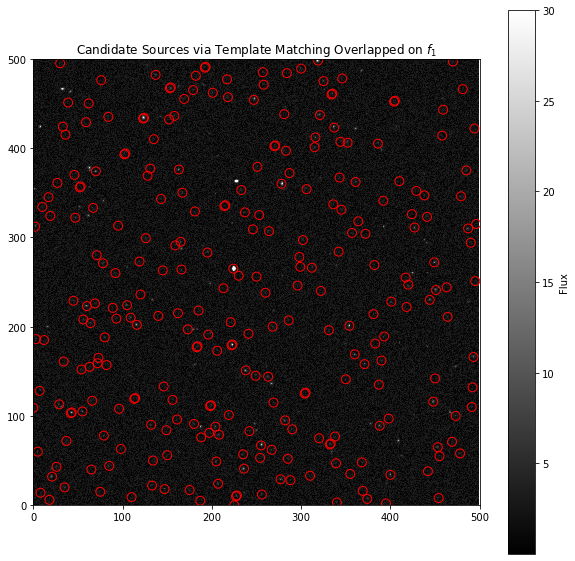

In [158]:
fig,ax = plt.subplots(figsize=(10, 10))
candidateSources = np.array(getCenteredCandidatePositions(templateMatch(0.5,100,500)))
print(len(candidatePositions))
candidateSources = np.flip(candidateSources,axis=1)
candidateImage = np.zeros((500, 500))
for candidate in candidateSources:
    ax.add_artist(plt.Circle((candidate[0], candidate[1]), 5, color='red', fill=False))
plt.imshow(f1image,vmax=30, cmap='gray',interpolation='None')
plt.colorbar(label='Flux')
plt.title("Candidate Sources via Template Matching Overlapped on $f_1$")
plt.xlim(0, 500)
plt.ylim(0, 500)
plt.show()

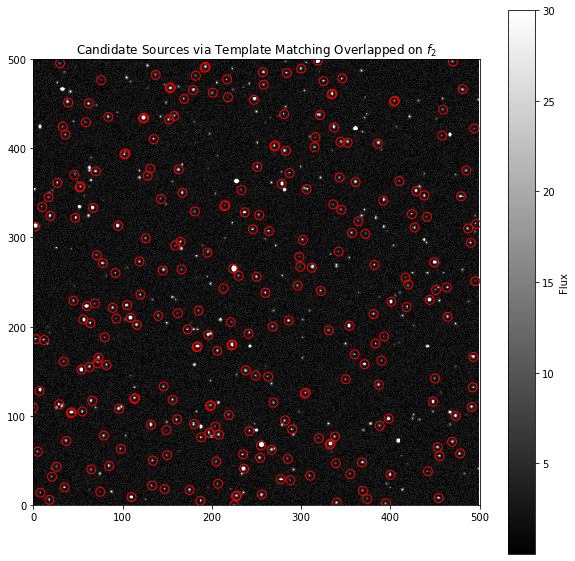

In [159]:
fig,ax = plt.subplots(figsize=(10, 10))
for candidate in candidateSources:
    ax.add_artist(plt.Circle((candidate[0], candidate[1]), 5, color='red', fill=False))
plt.imshow(f2image,vmax=30, cmap='gray',interpolation='None')
plt.colorbar(label='Flux')
plt.title("Candidate Sources via Template Matching Overlapped on $f_2$")
plt.xlim(0, 500)
plt.ylim(0, 500)
plt.show()

## Precision/Recall

In [199]:
def getPositionClassificationMetrics(proposedSources,trueSources):
    #in this case "trueSources" refers to the detectable sources with SNR>5
    truePositive = []
    trueNegative = []
    falsePositive = []
    falseNegative = []
    sourceFound = np.zeros(trueSources.shape[0])
    for i in range(len(proposedSources)):
        proposedX = proposedSources['x'].iloc[i]
        proposedY = proposedSources['y'].iloc[i]

        matchFound = False
        for j in range(len(trueSources)):
            trueX = trueSources['x'].iloc[j]
            trueY = trueSources['y'].iloc[j]
            if (proposedX == trueX and proposedY == trueY):
                sourceFound[j] = 1
                matchFound = True
                truePositive.append([proposedX,proposedY])
                break
        #if there was no match then it was either a false positive or true negative
        if(not matchFound):
            falsePositive.append([proposedX,proposedY])
    for j in range(len(trueSources)):
        if(sourceFound[j]!=1):
            falseNegative.append([trueSources['x'].iloc[j],trueSources['y'].iloc[j],trueSources['f1'].iloc[j],trueSources['color'].iloc[j],trueSources['f2'].iloc[j]])
        
    return truePositive, trueNegative, falsePositive, falseNegative

In [161]:
def getFlux1ClassificationMetrics(proposedSources,trueSources):
    #in this case "trueSources" refers to the detectable sources with SNR>5
    correct = []
    incorrect = []
    for i in range(len(proposedSources)):
        proposedX = proposedSources['x'].iloc[i]
        proposedY = proposedSources['y'].iloc[i]
        proposedFlux = proposedSources['f1'].iloc[i]
        proposedColor = proposedSources['color'].iloc[i]
        proposedF2 = proposedSources['f2'].iloc[i]

        matchFound = False
        for j in range(len(trueSources)):
            trueX = trueSources['x'].iloc[j]
            trueY = trueSources['y'].iloc[j]
            trueFlux = trueSources['f1'].iloc[j]
            #if there is a source within 5 pixels of the proposed source then it is a hit!
            if (np.sqrt((proposedX-trueX)**2+(proposedY-trueY)**2)<5):
                #consider it to be a correct match if the value has relative error of at most 10%
                if(np.abs(proposedFlux-trueFlux)/trueFlux<=0.1):
                    matchFound = True
                    correct.append([proposedX,proposedY,proposedFlux,proposedColor,proposedF2])
                break
        if(not matchFound):
            incorrect.append([proposedX,proposedY,proposedFlux,proposedColor,proposedF2])

In [162]:
def getFlux2ClassificationMetrics(proposedSources,trueSources):
    #in this case "trueSources" refers to the detectable sources with SNR>5
    correct = []
    incorrect = []
    for i in range(len(proposedSources)):
        proposedX = proposedSources['x'].iloc[i]
        proposedY = proposedSources['y'].iloc[i]
        proposedFlux = proposedSources['f1'].iloc[i]
        proposedColor = proposedSources['color'].iloc[i]
        proposedF2 = proposedSources['f2'].iloc[i]

        matchFound = False
        for j in range(len(trueSources)):
            trueX = trueSources['x'].iloc[j]
            trueY = trueSources['y'].iloc[j]
            trueFlux = trueSources['f1'].iloc[j]
            trueColor = trueSources['color'].iloc[j]
            trueF2 = trueSources['f2'].iloc[j]
            #if there is a source within 5 pixels of the proposed source then it is a hit!
            if (np.sqrt((proposedX-trueX)**2+(proposedY-trueY)**2)<5):
                #consider it to be a correct match if the value has relative error of at most 10%
                if(np.abs(proposedF2-trueF2)/trueF2<=0.1):
                    matchFound = True
                    correct.append([proposedX,proposedY,proposedFlux,proposedColor,proposedF2])
                break
        if(not matchFound):
            incorrect.append([proposedX,proposedY,proposedFlux,proposedColor,proposedF2])

In [163]:
def getColorClassificationMetrics(proposedSources,trueSources):
    #in this case "trueSources" refers to the detectable sources with SNR>5
    correct = []
    incorrect = []
    for i in range(len(proposedSources)):
        proposedX = proposedSources['x'].iloc[i]
        proposedY = proposedSources['y'].iloc[i]
        proposedFlux = proposedSources['f1'].iloc[i]
        proposedColor = proposedSources['color'].iloc[i]
        proposedF2 = proposedSources['f2'].iloc[i]

        matchFound = False
        for j in range(len(trueSources)):
            trueX = trueSources['x'].iloc[j]
            trueY = trueSources['y'].iloc[j]
            trueFlux = trueSources['f1'].iloc[j]
            trueColor = trueSources['color'].iloc[j]
            trueF2 = trueSources['f2'].iloc[j]
            #if there is a source within 5 pixels of the proposed source then it is a hit!
            if (np.sqrt((proposedX-trueX)**2+(proposedY-trueY)**2)<5):
                #consider it to be a correct match if the value has relative error of at most 10%
                if(np.abs(proposedColor-trueColor)/trueColor <=0.1):
                    matchFound = True
                    correct.append([proposedX,proposedY,proposedFlux,proposedColor,proposedF2])
                break
        if(not matchFound):
            incorrect.append([proposedX,proposedY,proposedFlux,proposedColor,proposedF2])

In [ ]:
def bayesianEvidence(candidateSources,threshold):
    bayesianCandidates = []
    trueCandidates = pd.DataFrame(candidateSources, columns=['x', 'y'])
    for proposedN in range(0,len(trueCandidates)):
        proposed = trueCandidates.iloc[proposedN]
        candidateX = int(proposed['x'])
        candidateY = int(proposed['y'])
        totalCurrentLikelihood = 0
        f1ProposedImage = gaussian_psf(f1image[candidateX, candidateY],candidateX,candidateY,500,fwhm=2.5)
        f2ProposedImage = gaussian_psf(f2image[candidateX, candidateY],candidateX,candidateY,500,fwhm=2.5)
        for x in range(max(candidateX-20,0), min(candidateX+20,499)):
            for y in range(max(candidateY-20,0), min(candidateY+20,499)):
                knownFlux1 = f1image[x, y]
                knownFlux2 = f2image[x,y]
                varFlux1 = knownFlux1
                varFlux2 = knownFlux2
                if(knownFlux1<1):
                    varFlux1 = 1
                if(knownFlux2<1):
                    varFlux2 = 1
                
                totalCurrentLikelihood += np.log(1/np.sqrt(2*np.pi*varFlux1))+(-0.5*(knownFlux1-f1ProposedImage[x, y])**2/varFlux1)
                totalCurrentLikelihood += np.log(1/np.sqrt(2*np.pi/varFlux2))+(-0.5*(knownFlux2-f2ProposedImage[x, y])**2/varFlux2)
        if(totalCurrentLikelihood>=threshold):
            bayesianCandidates.append([candidateX, candidateY])
    bayesianCandidates = pd.DataFrame(bayesianCandidates, columns=['x', 'y'])
    truePositive, trueNegative, falsePositive, falseNegative = getPositionClassificationMetrics(bayesianCandidates,df)
    return len(truePositive)/(len(truePositive)+len(falsePositive)), len(truePositive)/(len(truePositive)+len(falseNegative))
        

In [ ]:
bayesianPrecision = []
bayesianRecall = []
for i in np.linspace(-1e5,-1e4,10):
    potentialSources = [np.linspace(0, 500, 500), np.linspace(0, 500, 500)]
    potentialSources = np.transpose(potentialSources)
    temp = pd.DataFrame(potentialSources, columns=['x', 'y'])
    results = bayesianEvidence(temp,i)
    
    bayesianPrecision.append(results[0])
    bayesianRecall.append(results[1])

In [215]:
templatePrecision = []
templateRecall = []
for i in np.linspace(0.3,0.9,15):
    temp = templateMatch(i,100,500)
    temp = pd.DataFrame(temp, columns=['x', 'y'])
    truePositive, trueNegative, falsePositive, falseNegative = getPositionClassificationMetrics(temp,df)
    templatePrecision.append(len(truePositive)/(len(truePositive)+len(falsePositive)))
    templateRecall.append(len(truePositive)/(len(truePositive)+len(falseNegative)))

In [216]:
outlierPrecision = []
outlierRecall = []
for i in np.linspace(1,9,15):
    outliers = outlierDetection(50,25,i)
    outliers = pd.DataFrame(outliers, columns=['x', 'y'])
    truePositive, trueNegative, falsePositive, falseNegative = getPositionClassificationMetrics(outliers,df)
    outlierPrecision.append(len(truePositive)/(len(truePositive)+len(falsePositive)))
    outlierRecall.append(len(truePositive)/(len(truePositive)+len(falseNegative)))

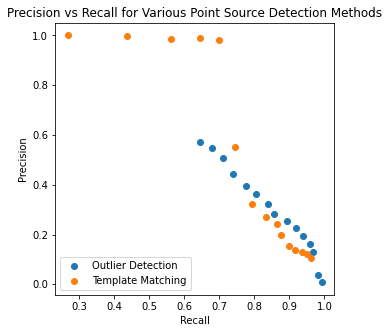

In [224]:
fig,ax = plt.subplots(figsize=(5, 5))
plt.scatter(outlierRecall,outlierPrecision,label='Outlier Detection')
#plt.scatter(bayesianRecall,bayesianPrecision,label='Bayesian Evidence')
plt.scatter(templateRecall,templatePrecision,label='Template Matching')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='lower left')
plt.title("Precision vs Recall for Various Point Source Detection Methods")
plt.show()


# WLS

In [16]:
trueCandidates = getCenteredCandidatePositions(templateMatch(0.73,100,500))
designMatrix = np.zeros((2*500*500,2*len(trueCandidates)+1))

for j in range(0,len(trueCandidates)):
    psfImage = gaussian_psf(1,int(trueCandidates[j][0]), int(trueCandidates[j][1]), size=500, fwhm=2.5)
    psfImage = psfImage.reshape(500*500, order='F')
    designMatrix[:250000,j] = psfImage
    designMatrix[250000:,len(trueCandidates)+j] = psfImage

#include a constant term for the background flux
designMatrix[:,2*len(trueCandidates)] = np.random.rand(500*500*2)
imageMatrix = np.append(f1image.reshape(500*500, order='F'),f2image.reshape(500*500, order='F'),axis=0)

/home/tegan/anaconda3/envs/research/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if sys.path[0] == '':


In [17]:
#we take the weights to be the inverse of the variance of the flux measurement for each pixel 
#because we model it as a poisson process we can say that the variance is equal to the flux (which is taken to be the mean hit count for a given obs. period)
weights = np.zeros(2*500*500)
for i in range(0,500):
    for j in range(0,500):
        weights[i+500*j] = 1/f1image[i,j]
        weights[i+500*j+250000] = 1/f2image[i,j]
        
weights = np.array(weights)

mod_wls = sm.WLS(imageMatrix, designMatrix, weights=weights)
res_wls = mod_wls.fit()
print(res_wls.summary())

                                 WLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.069
Model:                            WLS   Adj. R-squared (uncentered):              0.068
Method:                 Least Squares   F-statistic:                              88.42
Date:                Mon, 28 Apr 2025   Prob (F-statistic):                        0.00
Time:                        08:29:01   Log-Likelihood:                     -9.9599e+05
No. Observations:              500000   AIC:                                  1.993e+06
Df Residuals:                  499583   BIC:                                  1.997e+06
Df Model:                         417                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [18]:
trueCandidates = np.array(trueCandidates)
finalSources = np.array([trueCandidates[:,0],trueCandidates[:,1]]).T

proposedSources = pd.DataFrame(finalSources, columns=['x', 'y'])
proposedSources['f1'] = res_wls.params[:len(trueCandidates)]
proposedSources['f2'] = res_wls.params[len(trueCandidates):2*len(trueCandidates)]
proposedSources['log_f1'] = np.log(proposedSources['f1'])
proposedSources['log_f2'] = np.log(proposedSources['f2'])
proposedSources['color'] = np.log(proposedSources['f2']/proposedSources['f1'])
backgroundFlux = res_wls.params[-1]
print(proposedSources)

       x    y         f1          f2    log_f1    log_f2     color
0      2  395   4.636694   15.544405  1.534002  2.743701  1.209699
1      3  340   5.388263   26.225894  1.684223  3.266747  1.582524
2      5  188   1.472243   24.059311  0.386787  3.180522  2.793735
3      6   18   3.996661   24.154710  1.385459  3.184479  1.799020
4      8  454   4.185676   32.867671  1.431668  3.492490  2.060821
..   ...  ...        ...         ...       ...       ...       ...
203  489  300   0.804190   32.763644 -0.217920  3.489319  3.707239
204  491  193   3.604832   29.495425  1.282275  3.384235  2.101960
205  495   30   4.077581   18.879906  1.405504  2.938098  1.532594
206  496  306   3.067068   16.008586  1.120722  2.773125  1.652403
207  498  319  26.805043  270.317001  3.288590  5.599595  2.311005

[208 rows x 7 columns]


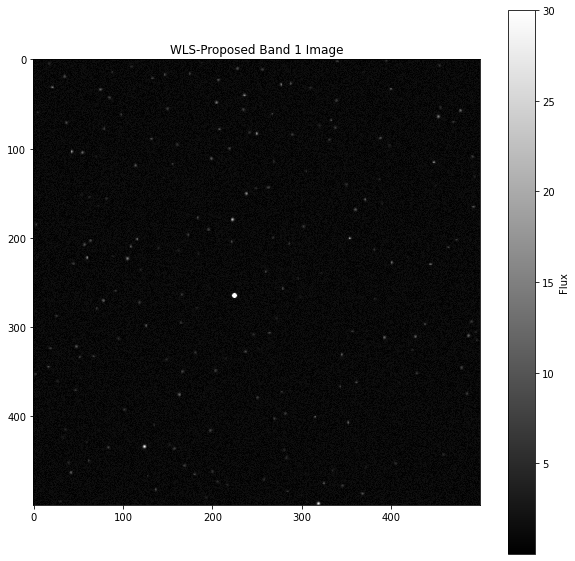

In [19]:
fig,ax = plt.subplots(figsize=(10, 10))
#adopt a "central" pixel view
x = np.linspace(0, 499, 500)
y = np.linspace(0, 499, 500)

xx, yy = np.meshgrid(x, y,indexing='ij')
wlsimage = np.zeros((500, 500))


for index, row in proposedSources.iterrows():
    wlsimage += gaussian_psf(row['f1'],int(row['x']), int(row['y']), size=500, fwhm=2.5)

randomNoise = np.random.uniform(0, 2*math.ceil(backgroundFlux),size=250000)
randomNoise = randomNoise.reshape((500, 500))

wlsimage += randomNoise


plt.imshow(wlsimage, vmax=30, cmap='gray',interpolation='None')
plt.colorbar(label='Flux')
plt.title("WLS-Proposed Band 1 Image")
plt.show()

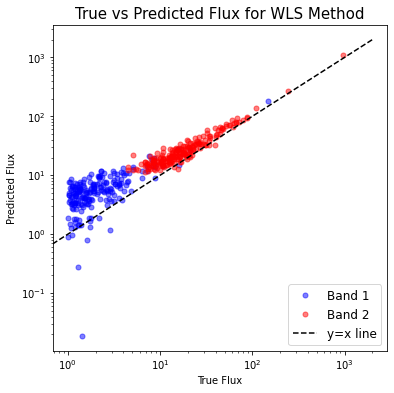

In [57]:
fig,ax = plt.subplots(figsize=(6,6))
trueVpredictedf1 = []
trueVpredictedf2 = []
sourceFound = np.zeros(df.shape[0])
for i in range(len(proposedSources)):
        proposedX = proposedSources['x'].iloc[i]
        proposedY = proposedSources['y'].iloc[i]

        matchFound = False
        for j in range(len(df)):
            trueX = df['x'].iloc[j]
            trueY = df['y'].iloc[j]
            if (proposedX == trueX and proposedY == trueY):
                sourceFound[j] = 1
                matchFound = True
                trueVpredictedf1.append([df['f1'].iloc[j],proposedSources['f1'].iloc[i]])
                trueVpredictedf2.append([df['f2'].iloc[j],proposedSources['f2'].iloc[i]])
                break
        if(not matchFound):
            trueVpredictedf1.append([0,proposedSources['f1'].iloc[i]])
            trueVpredictedf2.append([0,proposedSources['f2'].iloc[i]])

for j in range(len(df)):
        if(sourceFound[j]!=1):
            trueVpredictedf1.append([df['f1'].iloc[j],0])
            trueVpredictedf2.append([df['f2'].iloc[j],0])

trueVpredictedf1 = np.array(trueVpredictedf1)
trueVpredictedf2 = np.array(trueVpredictedf2)

plt.plot(trueVpredictedf1[:,0], trueVpredictedf1[:,1], 'o', markersize=5, color='blue', alpha=0.5, label='Band 1')
plt.plot(trueVpredictedf2[:,0], trueVpredictedf2[:,1], 'o', markersize=5, color='red', alpha=0.5, label='Band 2')
plt.plot(np.linspace(0, 2000,2000), np.linspace(0, 2000,2000), color='black', linestyle='--', label='y=x line')

plt.xlabel('True Flux')
plt.ylabel('Predicted Flux')
plt.legend(fontsize=12,loc='lower right')
plt.title('True vs Predicted Flux for WLS Method',fontsize=15)
plt.xscale('log')
plt.yscale('log')
plt.show()

In [ ]:
#take out the incorrectly predicted sources and the missed sources
trueVpredictedf1 = trueVpredictedf1[trueVpredictedf1[:,0] > 0]
trueVpredictedf1 = trueVpredictedf1[trueVpredictedf1[:,1] > 0]
trueVpredictedf2 = trueVpredictedf2[trueVpredictedf2[:,0] > 0]
trueVpredictedf2 = trueVpredictedf2[trueVpredictedf2[:,1] > 0]
#look at average flux error
print(np.average((trueVpredictedf1[:,1]-trueVpredictedf1[:,0])/trueVpredictedf1[:,0]))
print(np.average((trueVpredictedf2[:,1]-trueVpredictedf2[:,0])/trueVpredictedf2[:,0]))

1.891711335875683
0.5571397723982014


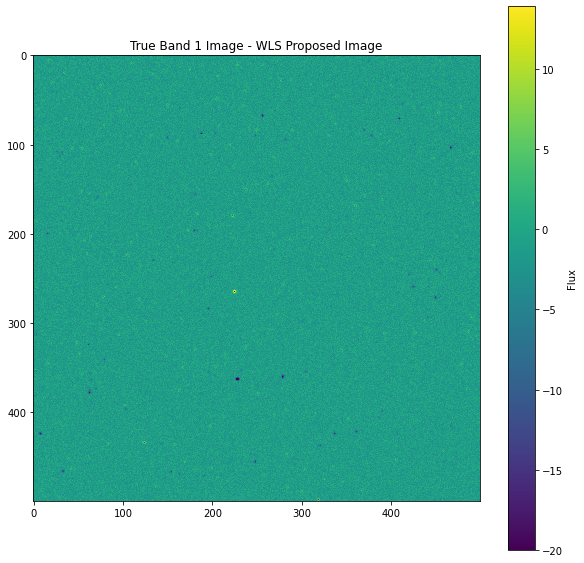

In [234]:
fig,ax = plt.subplots(figsize=(10, 10))
#adopt a "central" pixel view
x = np.linspace(0, 499, 500)
y = np.linspace(0, 499, 500)

xx, yy = np.meshgrid(x, y,indexing='ij')
wlsimage = np.zeros((500, 500))


for index, row in proposedSources.iterrows():
    wlsimage += gaussian_psf(row['f1'],int(row['x']), int(row['y']), size=500, fwhm=2.5)

randomNoise = np.random.uniform(0, 2*math.ceil(backgroundFlux),size=250000)
randomNoise = randomNoise.reshape((500, 500))

wlsimage += randomNoise


plt.imshow(wlsimage-f1image, vmin=-20,cmap='viridis',interpolation='None')
plt.colorbar(label='Flux')
plt.title("True Band 1 Image - WLS Proposed Image")
plt.show()

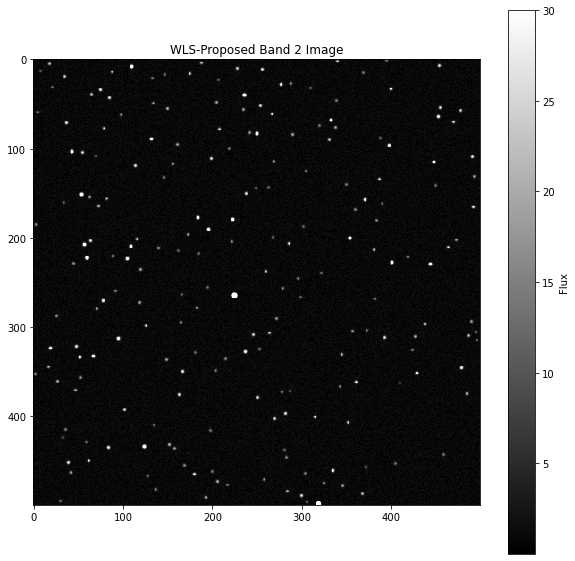

In [257]:
fig,ax = plt.subplots(figsize=(10, 10))
#adopt a "central" pixel view
x = np.linspace(0, 499, 500)
y = np.linspace(0, 499, 500)

xx, yy = np.meshgrid(x, y,indexing='ij')
wlsimage = np.zeros((500, 500))


for index, row in proposedSources.iterrows():
    wlsimage += gaussian_psf(row['f2'],int(row['x']), int(row['y']), size=500, fwhm=2.5)

randomNoise = np.random.uniform(0, 2*math.ceil(backgroundFlux),size=250000)
randomNoise = randomNoise.reshape((500, 500))

wlsimage += randomNoise


plt.imshow(wlsimage, vmax=30, cmap='gray',interpolation='None')
plt.colorbar(label='Flux')
plt.title("WLS-Proposed Band 2 Image")
plt.show()

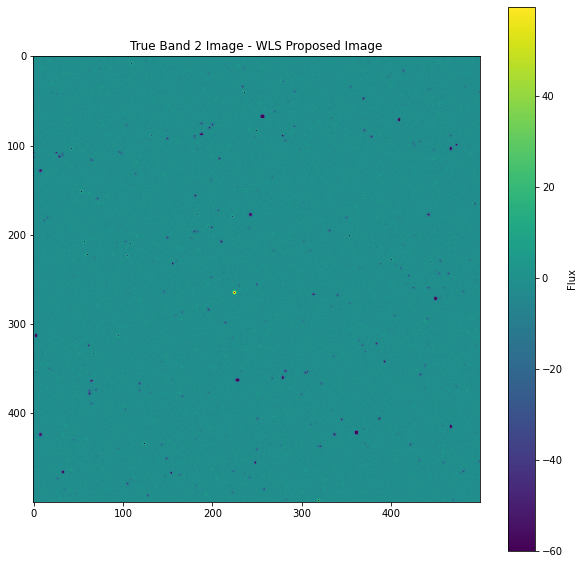

In [236]:
fig,ax = plt.subplots(figsize=(10, 10))
#adopt a "central" pixel view
x = np.linspace(0, 499, 500)
y = np.linspace(0, 499, 500)

xx, yy = np.meshgrid(x, y,indexing='ij')
wlsimage = np.zeros((500, 500))


for index, row in proposedSources.iterrows():
    wlsimage += gaussian_psf(row['f2'],int(row['x']), int(row['y']), size=500, fwhm=2.5)

randomNoise = np.random.uniform(0, 2*math.ceil(backgroundFlux),size=250000)
randomNoise = randomNoise.reshape((500, 500))

wlsimage += randomNoise


plt.imshow(wlsimage-f2image, vmin=-60,cmap='viridis',interpolation='None')
plt.colorbar(label='Flux')
plt.title("True Band 2 Image - WLS Proposed Image")
plt.show()

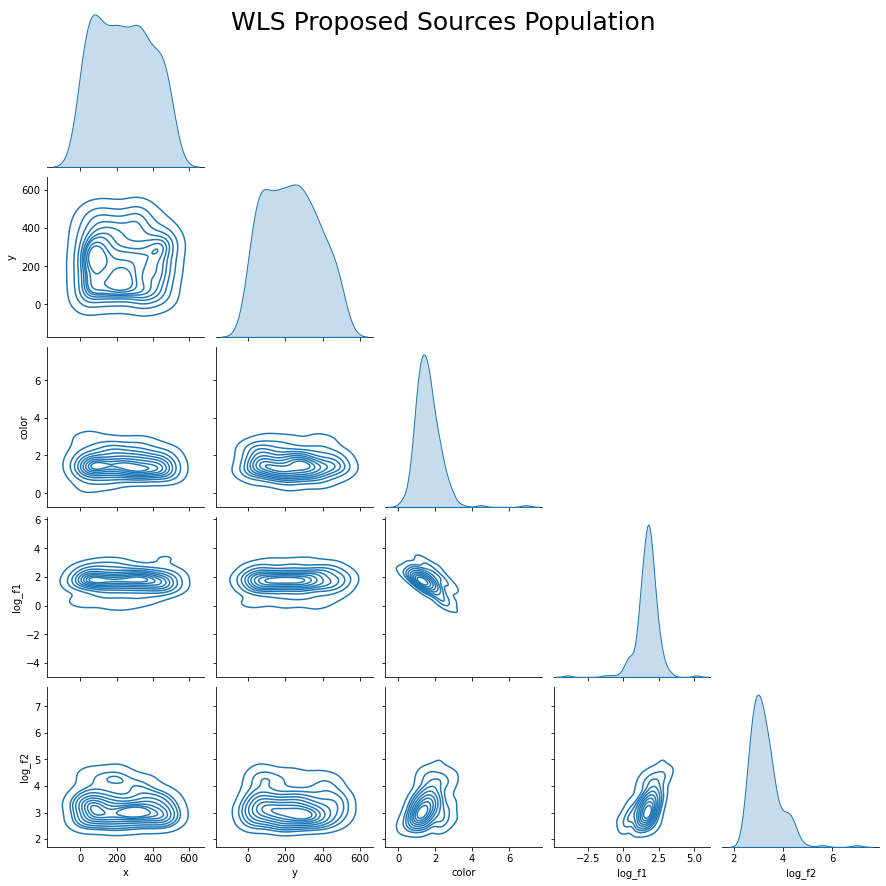

In [258]:
sns.pairplot(data=proposedSources, vars=['x', 'y', 'color', 'log_f1','log_f2'],kind='kde',corner=True)
plt.suptitle("WLS Proposed Sources Population",fontsize=25)
plt.show()